# Датасет

In [ ]:
!cp ./drive/MyDrive/us_cities.csv ./us_cities.csv

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

feature = 'Region'
size = 1000
train_ratio = 0.8

df = pd.read_csv('us_cities.csv')
df = df.dropna(ignore_index=True)
df[feature] = df[feature].map({'West': 0, 'Midwest': 0, 'Northeast': 1, 'South': 1})
df = df.iloc[:, 1:].drop(columns=['City', 'State', 'County', 'Division', 'Longitude', 'Latitude'])
for column in df:
    if column != 'Region':
        mean = df[column].mean()
        std = df[column].std()
        outliers = np.where((df[column] - mean) / std >= 3)[0]
        df = df.drop(index=outliers).reset_index(drop=True)

west_df = resample(df.loc[df[feature] == 0], n_samples=size).reset_index(drop=True)
east_df = resample(df.loc[df[feature] == 1], n_samples=size).reset_index(drop=True)
df = pd.concat([west_df, east_df])
target = pd.Series(df[feature])
df = df.drop(columns=[feature])
df = (df - df.mean()) / df.std()
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=train_ratio)
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

# Реализации

In [ ]:
import torch.nn as nn
import torch.optim as optim


class MultiLayerPerceptron(nn.Module):

    def __init__(self, n_layers, input_size, xavier=False, batch_norm=False):
        super(MultiLayerPerceptron, self).__init__()
        self.layers = nn.Sequential()
        for i in range(n_layers):
            layer = nn.Linear(input_size, input_size)
            if xavier:
                torch.nn.init.xavier_uniform_(layer.weight)
            self.layers.append(layer)
            if batch_norm:
                self.layers.append(nn.BatchNorm1d(input_size))
            self.layers.append(nn.ReLU())
        layer = nn.Linear(input_size, 1)
        self.layers.append(layer)
        if xavier:
            torch.nn.init.xavier_uniform_(layer.weight)
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        return self.layers(x).squeeze()


In [ ]:
class MLPClassifier:
    model = None
    train_history = None
    test_history = None

    def __init__(self, n_layers, input_size, xavier=False, batch_norm=False):
        self.model = MultiLayerPerceptron(n_layers, input_size, xavier, batch_norm)

    def fit(self, X, y, epochs, lr):
        criterion = nn.BCELoss()
        optimizer = optim.SGD(params=self.model.layers.parameters(), lr=lr)
        for epoch in range(epochs):
            prediction = self.model.forward(X)
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    def predict(self, X):
        return np.where(self.model.forward(X).detach().numpy() < 0.5, 0, 1)


In [ ]:
class ResidualBlock(nn.Module):

    def __init__(self, input_size, xavier=False):
        super(ResidualBlock, self).__init__()
        self.layer1 = nn.Linear(input_size, input_size)
        self.layer2 = nn.Linear(input_size, input_size)
        if xavier:
            torch.nn.init.xavier_uniform_(self.layer1.weight)
            torch.nn.init.xavier_uniform_(self.layer2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = torch.relu(out)
        return self.layer2(out) + x


In [ ]:
class ResidualNetwork(nn.Module):
    def __init__(self, n_layers, input_size, xavier=False, batch_norm=False, blocks=None):
        super(ResidualNetwork, self).__init__()
        self.layers = nn.Sequential()
        if blocks is not None:
            for block in blocks:
                self.layers.append(block)
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(input_size, 1))
            self.layers.append(nn.Sigmoid())
            return
        self.block_list = []
        for i in range(n_layers):
            block = ResidualBlock(input_size, xavier)
            self.layers.append(block)
            self.block_list.append(block)
            if batch_norm:
                self.layers.append(nn.BatchNorm1d(input_size))
            self.layers.append(nn.ReLU())
        layer = nn.Linear(input_size, 1)
        self.layers.append(layer)
        if xavier:
            torch.nn.init.xavier_uniform_(layer.weight)
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        return self.layers(x).squeeze()

    def cut(self, X):
        size = len(self.block_list)
        means = [0] * size
        blocks = {}
        for i in range(size):
            m = np.average(self.forward(X).detach().numpy())
            means[i] = m
            blocks[m] = self.block_list[i]
        means.sort()
        good_blocks = []
        for i in range(int(0.2 * size), size):
            good_blocks.append(blocks[means[i]])
        return good_blocks


In [ ]:
class ResNetClassifier:
    model = None
    train_history = None
    test_history = None

    def __init__(self, n_layers, input_size, xavier=False, batch_norm=False, blocks=None):
        self.model = ResidualNetwork(n_layers, input_size, xavier, batch_norm, blocks)

    def fit(self, X, y, epochs, lr, X_test=None, y_test=None):
        self.train_history = []
        self.test_history = []
        criterion = nn.BCELoss()
        optimizer = optim.SGD(params=self.model.layers.parameters(), lr=lr)
        for epoch in range(epochs):
            prediction = self.model.forward(X)
            loss = criterion(prediction, y)
            self.train_history.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if X_test is not None:
                with torch.no_grad():
                    output = self.model.forward(X_test)
                    loss = criterion(y_test, output)
                    self.test_history.append(loss.item())

    def predict(self, X):
        return np.where(self.model.forward(X).detach().numpy() < 0.5, 0, 1)

# Зависимость от кол-ва слоёв

In [ ]:
from sklearn.metrics import f1_score

layers = 20
mlp_train_scores = [0] * layers
mlp_test_scores = [0] * layers
for i in range(1, layers + 1):
    classifier = MLPClassifier(i, X_train.shape[1])
    classifier.fit(X_train, y_train, epochs=500, lr=0.1)
    mlp_train_scores[i - 1] = f1_score(y_train, classifier.predict(X_train))
    mlp_test_scores[i - 1] = f1_score(y_test, classifier.predict(X_test))

In [ ]:
resnet_train_scores = [0] * layers
resnet_test_scores = [0] * layers
for i in range(1, layers + 1):
    classifier = ResNetClassifier(i, X_train.shape[1])
    classifier.fit(X_train, y_train, epochs=500, lr=0.1)
    resnet_train_scores[i - 1] = f1_score(y_train, classifier.predict(X_train))
    resnet_test_scores[i - 1] = f1_score(y_test, classifier.predict(X_test))

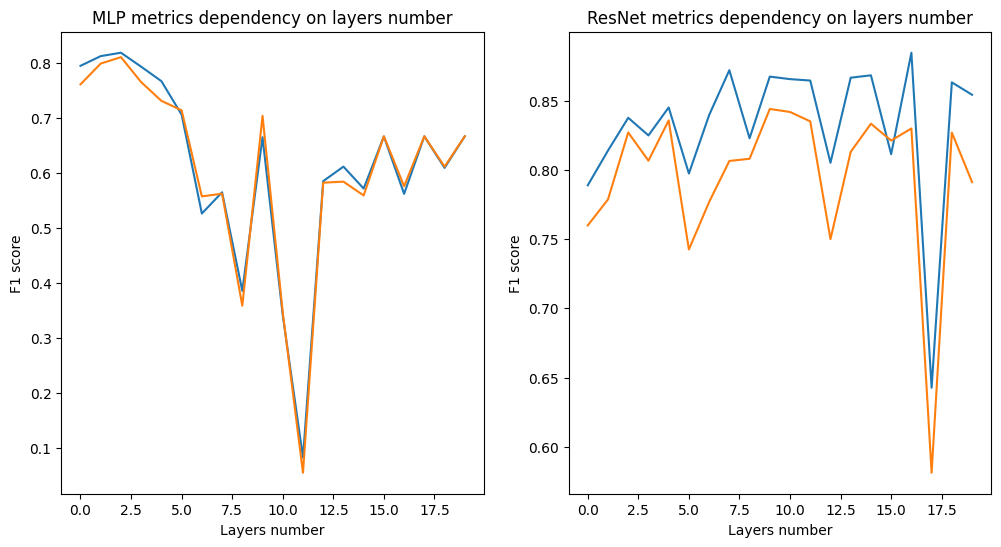

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('MLP metrics dependency on layers number')
ax[0].set_xlabel('Layers number')
ax[0].set_ylabel('F1 score')
ax[0].plot(mlp_train_scores, label='Train')
ax[0].plot(mlp_test_scores, label='Test')

ax[1].set_title('ResNet metrics dependency on layers number')
ax[1].set_xlabel('Layers number')
ax[1].set_ylabel('F1 score')
ax[1].plot(resnet_train_scores, label='Train')
ax[1].plot(resnet_test_scores, label='Test')

# Xavier

In [ ]:
layers = 20
mlp_train_scores = [0] * layers
mlp_test_scores = [0] * layers
for i in range(1, layers + 1):
    classifier = MLPClassifier(i, X_train.shape[1], xavier=True)
    classifier.fit(X_train, y_train, epochs=500, lr=0.1)
    mlp_train_scores[i - 1] = f1_score(y_train, classifier.predict(X_train))
    mlp_test_scores[i - 1] = f1_score(y_test, classifier.predict(X_test))

In [ ]:
resnet_train_scores = [0] * layers
resnet_test_scores = [0] * layers
for i in range(1, layers + 1):
    classifier = ResNetClassifier(i, X_train.shape[1], xavier=True)
    classifier.fit(X_train, y_train, epochs=500, lr=0.1)
    resnet_train_scores[i - 1] = f1_score(y_train, classifier.predict(X_train))
    resnet_test_scores[i - 1] = f1_score(y_test, classifier.predict(X_test))

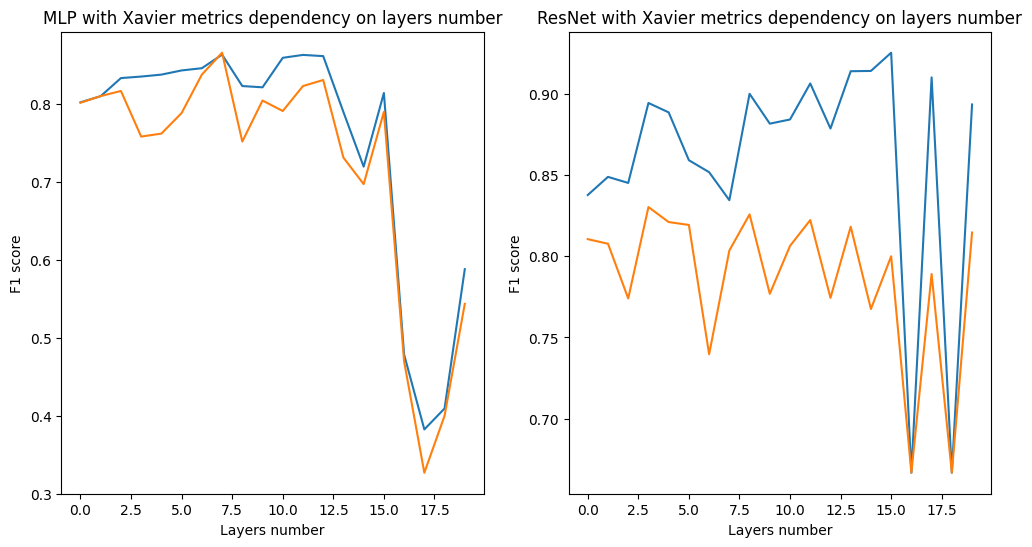

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('MLP with Xavier metrics dependency on layers number')
ax[0].set_xlabel('Layers number')
ax[0].set_ylabel('F1 score')
ax[0].plot(mlp_train_scores, label='Train')
ax[0].plot(mlp_test_scores, label='Test')

ax[1].set_title('ResNet with Xavier metrics dependency on layers number')
ax[1].set_xlabel('Layers number')
ax[1].set_ylabel('F1 score')
ax[1].plot(resnet_train_scores, label='Train')
ax[1].plot(resnet_test_scores, label='Test')

# Batch-norm

In [ ]:
layers = 20
mlp_train_scores = [0] * layers
mlp_test_scores = [0] * layers
for i in range(1, layers + 1):
    classifier = MLPClassifier(i, X_train.shape[1], batch_norm=True)
    classifier.fit(X_train, y_train, epochs=500, lr=0.1)
    mlp_train_scores[i - 1] = f1_score(y_train, classifier.predict(X_train))
    mlp_test_scores[i - 1] = f1_score(y_test, classifier.predict(X_test))

In [ ]:
resnet_train_scores = [0] * layers
resnet_test_scores = [0] * layers
for i in range(1, layers + 1):
    classifier = ResNetClassifier(i, X_train.shape[1], batch_norm=True)
    classifier.fit(X_train, y_train, epochs=500, lr=0.1)
    resnet_train_scores[i - 1] = f1_score(y_train, classifier.predict(X_train))
    resnet_test_scores[i - 1] = f1_score(y_test, classifier.predict(X_test))

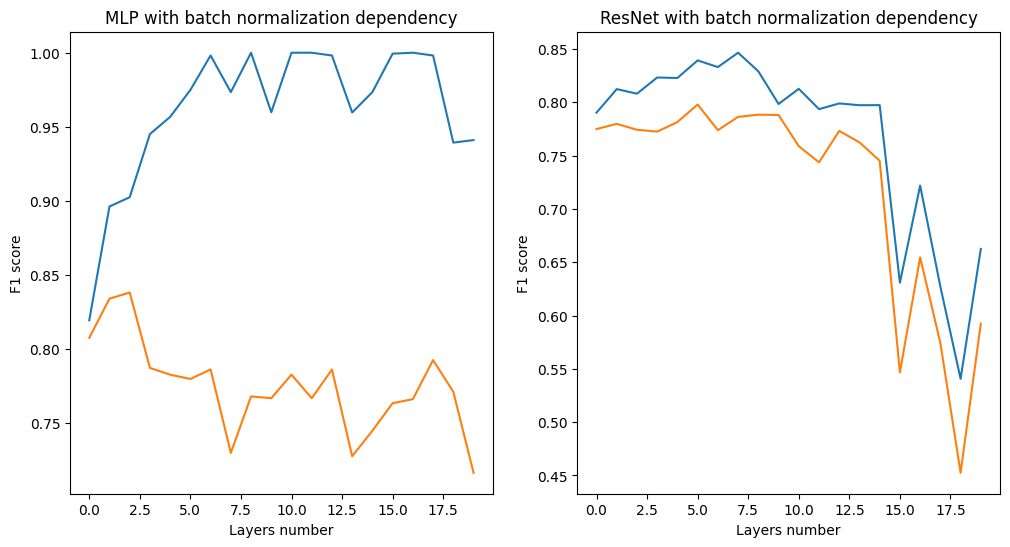

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('MLP with batch normalization dependency')
ax[0].set_xlabel('Layers number')
ax[0].set_ylabel('F1 score')
ax[0].plot(mlp_train_scores, label='Train')
ax[0].plot(mlp_test_scores, label='Test')

ax[1].set_title('ResNet with batch normalization dependency')
ax[1].set_xlabel('Layers number')
ax[1].set_ylabel('F1 score')
ax[1].plot(resnet_train_scores, label='Train')
ax[1].plot(resnet_test_scores, label='Test')

# Прореживание ResNET

In [ ]:
X_first, X_second, y_first, y_second = train_test_split(X_train, y_train, train_size=0.5)
resnet = ResNetClassifier(n_layers=50, input_size=X_first.shape[1])
resnet.fit(X_first, y_first, epochs=500, lr=0.1, X_test=X_test, y_test=y_test)
good_blocks = resnet.model.cut(X_first)

In [ ]:
ordinary_resnet = ResNetClassifier(n_layers=50, input_size=X_first.shape[1])
ordinary_resnet.fit(X_train, y_train, epochs=500, lr=0.1, X_test=X_test, y_test=y_test)

In [ ]:
new_resnet = ResNetClassifier(n_layers=50, input_size=X_first.shape[1], blocks=good_blocks)
new_resnet.fit(X_second, y_second, epochs=500, lr=0.1, X_test=X_test, y_test=y_test)

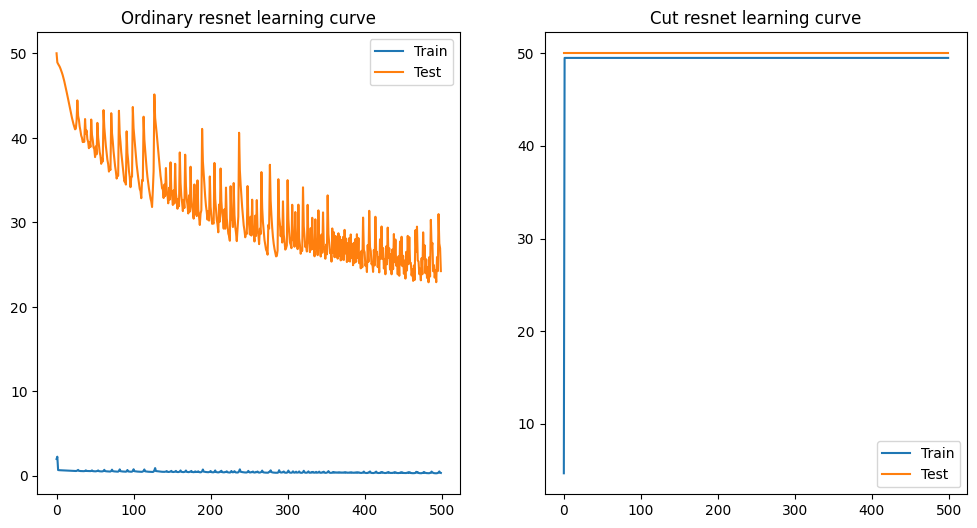

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Ordinary resnet learning curve')
ax[0].plot(ordinary_resnet.train_history, label='Train')
ax[0].plot(ordinary_resnet.test_history, label='Test')
ax[0].legend()
ax[1].set_title('Cut resnet learning curve')
ax[1].plot(new_resnet.train_history, label='Train')
ax[1].plot(new_resnet.test_history, label='Test')
ax[1].legend()